# `winning_times_are_higher_in_extreme_weather_conditions.ipynb`

### Author: Anthony Hein

#### Last updated: 11/22/2021

# Overview:

This notebook shows that winning times are higher in extreme weather conditions.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `races_featurized.csv`

In [3]:
races_featurized = pd.read_csv(f"{BASE_DIR}/data/streamline/races_featurized.csv", low_memory=False) 
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,1,0,0,0,0,0,0,1,1.350363
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,1,0,0,1,0,0,0,0,1,1.995151
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,1,0,0,0,0,0,0,1,0,1.786421
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,1,0,0,0,0,0,1,0,1.611062
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,1,0,0,0,0,0,1,0,0,1.254374


In [4]:
races_featurized.shape

(20201, 129)

In [5]:
list(races_featurized.columns)

['rid',
 'course',
 'title',
 'winningTime',
 'metric',
 'ncond',
 'class',
 'runners',
 'margin',
 '1st_place_rank_in_odds',
 '2nd_place_rank_in_odds',
 '3rd_place_rank_in_odds',
 '1st_rank_in_odds_place',
 '2nd_rank_in_odds_place',
 '3rd_rank_in_odds_place',
 'placeAvailable',
 'showAvailable',
 'favoriteWon',
 'favoritePlaced',
 'favoriteShowed',
 'lat',
 'lng',
 'datetime',
 'station no',
 'station name',
 'station lat',
 'station lng',
 'dist to station',
 'station reading date',
 'temp',
 'msl',
 'rain',
 'rhum',
 'station reading timedelta',
 'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 '

---

## Load `horses_selected_trimmed_clean.csv`

In [6]:
horses_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_selected_trimmed_clean.csv", low_memory=False) 
horses_clean.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,RPR,TR,OR,father,mother,gfather,weight,res_win,res_place,res_show
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,102.0,NaN,NaN,King's Ride,Browne's Return,Deep Run,73,1,1,0
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,94.0,NaN,NaN,Long Pond,Courtlough Lady,Giolla Mear,73,0,1,0
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,92.0,NaN,NaN,Nordico,Over The Seas,North Summit,71,0,0,0
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,NaN,NaN,Roselier,Miss Reindeer,Reindeer,73,0,0,0
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,NaN,NaN,Noalto,Elena's Beauty,Tarqogan,66,0,0,0


In [7]:
horses_clean.shape

(202304, 22)

---

## Winning Time Metrics by Distance

In [8]:
distance_to_avg_winning_time = races_featurized[['metric', 'winningTime']].groupby('metric').mean().to_dict('index')
distance_to_avg_winning_time = { k: v['winningTime'] for k,v in distance_to_avg_winning_time.items()}
distance_to_avg_winning_time

{1005.0: 60.929309372797746,
 1105.5: 73.11236363636364,
 1206.0: 74.17711014176663,
 1306.5: 88.1844,
 1407.0: 89.49708482287944,
 1507.5: 98.96113879003559,
 1609.0: 102.22887272727273,
 1709.5: 110.01462365591398,
 1810.0: 121.27736408566722,
 1910.5: 125.72578595317727,
 2011.0: 133.33706802721088,
 2111.5: 136.67369538077403,
 2212.0: 149.63857798165137,
 2312.5: 154.50078125,
 2413.0: 161.63288163716814,
 2513.5: 171.3983211678832,
 2614.0: 173.8580971659919,
 2714.5: 186.55599999999998,
 2815.0: 192.12592465753423,
 2915.5: 205.68,
 3016.0: 202.59560000000002,
 3116.5: 230.025,
 3218.0: 242.131,
 3318.5: 248.48691428571428,
 3419.0: 246.2172972972973,
 3519.5: 256.8741935483871,
 3620.0: 268.9958227848101,
 3720.5: 287.12380952380954,
 3821.0: 284.768253968254,
 3921.5: 294.4655172413793,
 4022.0: 310.04133333333334,
 4122.5: 307.94716981132075,
 4223.0: 338.05652173913046,
 4323.5: 359.8,
 4424.0: 345.8732142857143,
 4524.5: 363.3,
 4625.0: 376.5777777777778,
 4725.5: 393.9,
 4

In [9]:
distance_to_std_winning_time = races_featurized[['metric', 'winningTime']].groupby('metric').std().to_dict('index')
distance_to_std_winning_time = { k: v['winningTime'] for k,v in distance_to_std_winning_time.items()}
distance_to_std_winning_time

{1005.0: 2.9264637005575165,
 1105.5: 3.4837006524226792,
 1206.0: 3.0873141419176315,
 1306.5: 7.002023371802623,
 1407.0: 4.551935338801339,
 1507.5: 4.439027900174284,
 1609.0: 4.964736972568227,
 1709.5: 5.789278169364809,
 1810.0: 6.481043643106916,
 1910.5: 5.497232033902799,
 2011.0: 7.174769027252095,
 2111.5: 4.7522177535431975,
 2212.0: 5.569577360784376,
 2312.5: 8.334741880795605,
 2413.0: 9.31340419927159,
 2513.5: 9.923268745830441,
 2614.0: 9.595510553757332,
 2714.5: 9.491458382262557,
 2815.0: 12.115716973061438,
 2915.5: nan,
 3016.0: 2.994790031593752,
 3116.5: 13.404343645678022,
 3218.0: 18.49273331747957,
 3318.5: 15.840804311279253,
 3419.0: 16.532867135541988,
 3519.5: 12.130896304943425,
 3620.0: 19.092555075758604,
 3720.5: 23.355318554066105,
 3821.0: 21.006230126488294,
 3921.5: 20.60719839317717,
 4022.0: 22.089730322353077,
 4122.5: 21.61130939483008,
 4223.0: 27.529914738945298,
 4323.5: 19.496812926366065,
 4424.0: 18.21481406160111,
 4524.5: 15.75150786

In [10]:
races_featurized[(races_featurized['metric'] == 2915.5) | (races_featurized['metric'] == 6737.5)]

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
669,128786,Punchestown,Friends First Cross Country Chase for the La T...,574.40,6737.5,11,0,10,1.171435,2,...,0,1,0,0,0,0,0,1,0,2.009498
15864,117404,Listowel,Bryan MacMahon (Q.R.) Race,205.68,2915.5,1,0,4,1.121037,1,...,0,1,0,1,0,0,1,0,0,0.715347


In [11]:
def normalize_winning_time(row: pd.core.frame.DataFrame) -> float:
    avg = distance_to_avg_winning_time[row['metric']]
    sd = distance_to_std_winning_time[row['metric']]
    
    return 0 if pd.isna(sd) else (row['winningTime'] - avg) / sd

In [12]:
races_featurized['normalized_winning_time'] = races_featurized.apply(normalize_winning_time, axis = 1)
races_featurized['normalized_winning_time'].head()

0   -0.360286
1    0.707107
2    2.587615
3   -1.445979
4   -0.351725
Name: normalized_winning_time, dtype: float64

In [13]:
races_featurized[['rid', 'winningTime', 'metric']].head()

,rid,winningTime,metric
0,302858,277.2,3821.0
1,291347,447.2,5229.0
2,75447,318.4,3620.0
3,358038,533.9,6637.0
4,89211,59.9,1005.0


In [14]:
distance_to_avg_winning_time[3821.0]

284.768253968254

In [15]:
distance_to_avg_winning_time[5229.0]

443.15

---

## Winning Times are Higher In Extreme Weather Conditions

In [16]:
dfa = races_featurized[
    ((races_featurized['temp_level_1'] == 1) | (races_featurized['temp_level_2'] == 1) | (races_featurized['temp_level_3'] == 1)) &
    ((races_featurized['pressure_level_3'] == 1) | (races_featurized['pressure_level_4'] == 1)) &
    ((races_featurized['rhum_level_1'] == 1) | (races_featurized['rhum_level_2'] == 1) | (races_featurized['rhum_level_3'] == 1)) &
    (races_featurized['is_raining'] == 0)
]

dfb = races_featurized[
    ~(((races_featurized['temp_level_1'] == 1) | (races_featurized['temp_level_2'] == 1) | (races_featurized['temp_level_3'] == 1)) &
    ((races_featurized['pressure_level_3'] == 1) | (races_featurized['pressure_level_4'] == 1)) &
    ((races_featurized['rhum_level_1'] == 1) | (races_featurized['rhum_level_2'] == 1) | (races_featurized['rhum_level_3'] == 1)) &
    (races_featurized['is_raining'] == 0))
]

len(dfa), len(dfb)

(10520, 9681)

In [17]:
np.mean(dfa['normalized_winning_time'])

-0.11573041015464386

In [18]:
np.mean(dfb['normalized_winning_time'])

0.12576013994699325

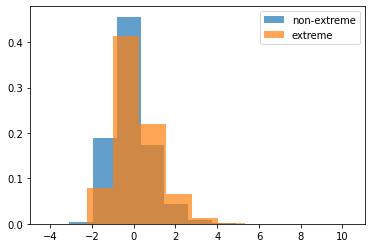

In [19]:
plt.hist(dfa['normalized_winning_time'], alpha = 0.7, density=True, label="non-extreme")
plt.hist(dfb['normalized_winning_time'], alpha = 0.7, density=True, label="extreme")
plt.legend()

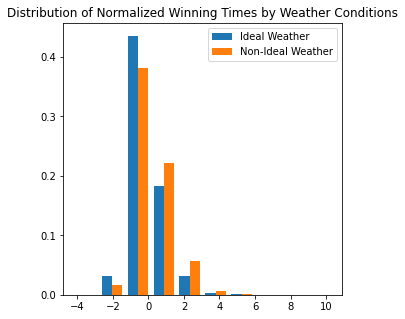

In [28]:
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(1, 1)

ax1 = fig.add_subplot(gs[0:1, 0:1])

ax1.set_title("Distribution of Normalized Winning Times by Weather Conditions")
ax1.hist([dfa['normalized_winning_time'], dfb['normalized_winning_time']],
         label=['Ideal Weather', 'Non-Ideal Weather'],
         density=True)
ax1.legend()

plt.show()

In [41]:
dfa_1 = dfa[(dfa['normalized_winning_time'] < 5) & (dfa['normalized_winning_time'] > -5)]
dfb_1 = dfb[(dfb['normalized_winning_time'] < 5) & (dfb['normalized_winning_time'] > -5)]

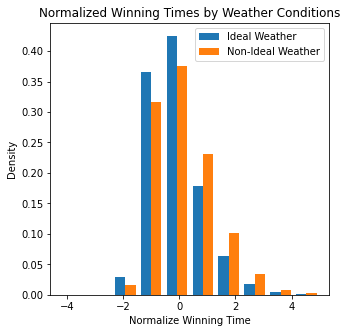

In [44]:
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(1, 1)

ax1 = fig.add_subplot(gs[0:1, 0:1])

ax1.set_title("Normalized Winning Times by Weather Conditions")
ax1.hist([dfa_1['normalized_winning_time'], dfb_1['normalized_winning_time']],
         label=['Ideal Weather', 'Non-Ideal Weather'],
         density=True)
ax1.set_xlabel("Normalize Winning Time")
ax1.set_ylabel("Density")
ax1.legend()

fig.savefig(f"{BASE_DIR}/figures/winning_times_distr.png")

plt.show()

In [21]:
stats.ttest_ind(dfa['normalized_winning_time'],
                dfb['normalized_winning_time'],
                equal_var=False)

Ttest_indResult(statistic=-17.20292248562827, pvalue=7.794649616375757e-66)